#1. Data discretization

1.1 Loading data

In [1]:
import pandas as pd
import re

df = pd.read_csv('Cellphone.csv')
df.info()
df = df.rename(columns={'cpu core': 'cpu_core',
                        'internal mem': 'internal_mem'})
df = df.astype(float)
y = df['Price']
X = df.drop(columns=['Product_id', 'Price', 'resoloution', 'cpu freq', 'Front_Cam', 'thickness'])

print(X.head())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product_id    161 non-null    int64  
 1   Price         161 non-null    int64  
 2   Sale          161 non-null    int64  
 3   weight        161 non-null    float64
 4   resoloution   161 non-null    float64
 5   ppi           161 non-null    int64  
 6   cpu core      161 non-null    int64  
 7   cpu freq      161 non-null    float64
 8   internal mem  161 non-null    float64
 9   ram           161 non-null    float64
 10  RearCam       161 non-null    float64
 11  Front_Cam     161 non-null    float64
 12  battery       161 non-null    int64  
 13  thickness     161 non-null    float64
dtypes: float64(8), int64(6)
memory usage: 17.7 KB
   Sale  weight    ppi  cpu_core  internal_mem    ram  RearCam  battery
0  10.0   135.0  424.0       8.0          16.0  3.000    13.00   2610.0
1  10.0   12

1.2 Clustering each feature

In [2]:
from sklearn.cluster import KMeans

models = {}
labels = {}

n_clusters = 4

for col in X.columns:
  model = KMeans(n_clusters=n_clusters)
  model.fit(X[[col]])
  centers = model.cluster_centers_.tolist()
  centers = sum(centers, [])
  centers = sorted(centers)
  models[col] = centers
  labels[col] = model.labels_

models

{'Sale': [147.46715328467343, 1671.4, 3840.8, 8894.5],
 'weight': [110.62790697674417, 166.5148148148148, 399.0, 753.0],
 'ppi': [164.37931034482767,
  263.76666666666677,
  412.8478260869566,
  552.3076923076924],
 'cpu_core': [0.16666666666666785,
  2.0000000000000004,
  4.000000000000001,
  7.925925925925924],
 'internal_mem': [9.18407843137252, 32.0, 64.0, 127.99999999999997],
 'ram': [0.6855483870967738, 1.9358974358974357, 3.437499999999999, 6.0],
 'RearCam': [1.849999999999996,
  6.680851063829783,
  13.901538461538458,
  20.936842105263153],
 'battery': [1546.8888888888882,
  2756.1842105263163,
  3844.117647058823,
  7966.666666666666]}

1.3 Storing clustered data to dataframe

In [3]:
import pandas as pd

X_clust = pd.DataFrame(data=labels)
X_clust.head() 

,Sale,weight,ppi,cpu_core,internal_mem,ram,RearCam,battery
0,0,3,1,0,0,1,0,0
1,0,3,2,3,0,0,3,2
2,0,3,2,1,0,3,0,2
3,0,3,2,3,0,0,3,2
4,0,3,2,3,0,0,3,2


1.4 Clustering target value

In [4]:
model = KMeans(n_clusters=n_clusters)
model.fit(y.to_frame())
y_centers = model.cluster_centers_.tolist()
y_centers = sum(y_centers, [])
y_centers = sorted(y_centers)
y_labels = model.labels_

y_centers

[1077.9285714285718,
 1862.5490196078435,
 2570.4909090909096,
 3339.3333333333335]

#2. Fuzzy modelling

2.1 Fuzzylogic package

In [5]:
!pip install fuzzylogic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from fuzzylogic.functions import S, R, triangular

def make_fuzzy_set(col_min, col_max, center):
  if col_min == center:
    return S(col_min, col_max)
  elif col_max == center:
    return R(col_min, col_max)
  else:
    return triangular(col_min, col_max, c=center)

2.2 Creating fuzzy variables

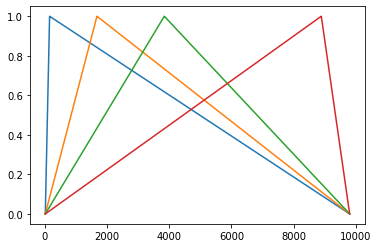

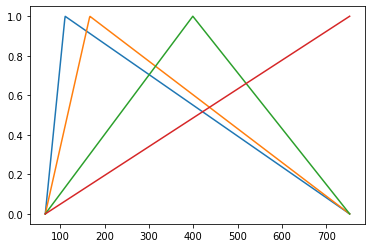

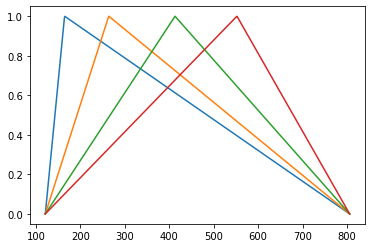

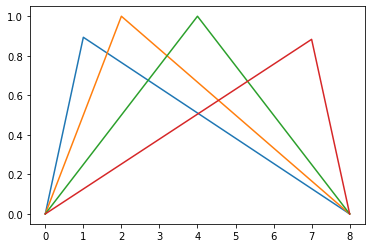

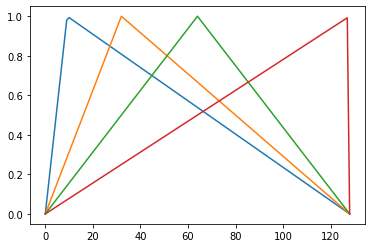

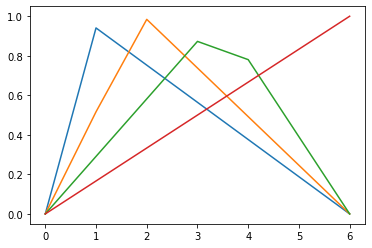

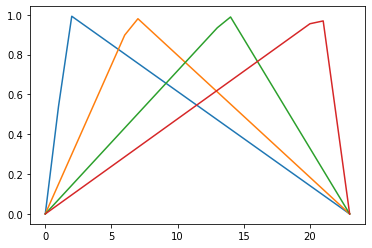

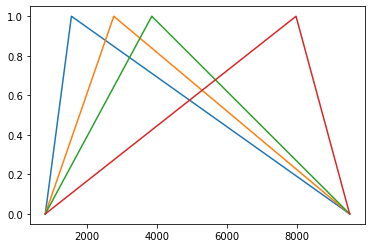

In [7]:
from fuzzylogic.classes import Domain
from matplotlib import pyplot as plt

for key, value in models.items():
  plt.figure()
  X_col = X[key]
  col_min = X_col.min()
  col_max = X_col.max()
  exec(f'{key} = Domain(key, col_min, col_max)')
  for i, rank in enumerate(['very_low', 'low', 'high', 'very_high']):
     exec(f'{key}.{rank} = make_fuzzy_set(col_min, col_max, value[{i}])')
     exec(f'{key}.{rank}.plot()')

2.3 Creating fuzzy variable for target variable

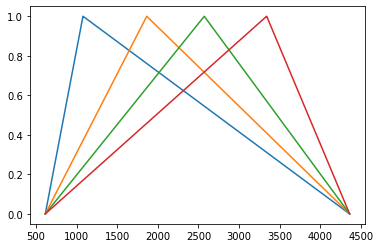

In [8]:
y_min = y.min()
y_max = y.max()
exec(f'{y.name} = Domain(y.name, y_min, y_max)')
for i, rank in enumerate(['very_low', 'low', 'high', 'very_high']):
  exec(f'{y.name}.{rank} = make_fuzzy_set(y_min, y_max, y_centers[{i}])')
  exec(f'{y.name}.{rank}.plot()')


#3. Rules learning

3.1 Fitting naive bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_clust, y_labels)

model.feature_log_prob_

array([[-2.22254239, -5.48063892, -1.38629436, -3.28341435, -1.56861592,
        -1.79175947, -2.77258872, -1.81707728],
       [-3.38308563, -2.48229909, -1.42624641, -2.65219812, -2.28447334,
        -1.42624641, -2.33711708, -2.01620936],
       [-3.42317629, -1.509527  , -2.57587843, -1.509527  , -5.62040087,
        -5.62040087, -1.27659544, -1.81373838],
       [-4.29045944, -1.96807172, -1.58240924, -1.91091331, -4.80128506,
        -1.80555279, -1.98787435, -1.69520473]])

3.2 Sampling feature combinations

In [10]:
from itertools import product

X_comb = []
for comb in product(*len(X_clust.columns)*[[0, 1, 2, 3]]):
  X_comb.append(comb)
X_comb = pd.DataFrame(X_comb, columns=X_clust.columns)

X_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65536 entries, 0 to 65535
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Sale          65536 non-null  int64
 1   weight        65536 non-null  int64
 2   ppi           65536 non-null  int64
 3   cpu_core      65536 non-null  int64
 4   internal_mem  65536 non-null  int64
 5   ram           65536 non-null  int64
 6   RearCam       65536 non-null  int64
 7   battery       65536 non-null  int64
dtypes: int64(8)
memory usage: 4.0 MB


3.3 Predicting labels for sampled combinations

In [11]:
preds = model.predict(X_comb)
df = X_comb.copy()
df['pred'] = preds
df.to_csv('data_and_predicts.csv')

preds[:10]
print(set(preds))

{0, 1, 2, 3}


#4. Fuzzy inference

4.1 Mapping labels to fuzzy sets

In [12]:
map = {0: 'very_low',
      1: 'low',
      2: 'high',
      3: 'very_high'}

4.2 Composing inference rules from sampled feature combinations and predicted labels

In [13]:
from fuzzylogic.classes import Rule

rules = []
for i, row in X_comb.iterrows():
  cond = []
  for col in X_comb.columns:
    cond.append('.'.join([col, map[row[col]]]))
  cond = ', '.join(cond)
  cons = '.'.join([y.name, map[preds[i]]])
  rules.append(f'({cond}): {cons}')

rules = eval('Rule({' + ',\n'.join(rules) + ',})')

rules

4.3 Formatting input data for inference

In [14]:
X_test = X[:200]
values = []
for i, row in X_test.iterrows():
  value = {}
  for col in X_test.columns:
    value[eval(col)] = row[col]
  values.append(value)

values[:5]

[{Domain('Sale', 10.0, 9807.0, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f1f42d934c0>), 'low': Set(<function triangular.<locals>.f at 0x7f1f4244ab80>), 'high': Set(<function triangular.<locals>.f at 0x7f1f424d8310>), 'very_high': Set(<function triangular.<locals>.f at 0x7f1f424d8a60>)}): 10.0,
  Domain('weight', 66.0, 753.0, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f1f424dc790>), 'low': Set(<function triangular.<locals>.f at 0x7f1f424cae50>), 'high': Set(<function triangular.<locals>.f at 0x7f1f424d05e0>), 'very_high': Set(<function R.<locals>.f at 0x7f1f424d0dc0>)}): 135.0,
  Domain('ppi', 121.0, 806.0, res=1, sets={'very_low': Set(<function triangular.<locals>.f at 0x7f1f424e08b0>), 'low': Set(<function triangular.<locals>.f at 0x7f1f4241b040>), 'high': Set(<function triangular.<locals>.f at 0x7f1f4241b700>), 'very_high': Set(<function triangular.<locals>.f at 0x7f1f4241be50>)}): 424.0,
  Domain('cpu_core', 0.0, 8.0, res=1, sets={'ve

4.4 Running fuzzy inference

In [15]:
preds = [rules(x) for x in values]

preds[:10]

[None,
 None,
 None,
 2407.2175015325543,
 2407.2175015325543,
 2407.2175015325543,
 2407.2175015343596,
 2407.2175015343596,
 2407.2175015325543,
 2407.217501532798]

#5. Comparing accuracy

5.1 Matching inference result with true labels

In [16]:
y_test = y[:200]
df_test = pd.DataFrame(data = {'y_pred': preds, 'y_true': y_test})
df_test = df_test.dropna()

df_test

,y_pred,y_true
3,2407.217502,1315.0
4,2407.217502,1749.0
5,2407.217502,2137.0
6,2407.217502,1238.0
7,2407.217502,2137.0
...,...,...
143,2348.567204,2508.0
144,2370.003325,1921.0
145,2369.727625,1921.0
148,2312.077197,3055.0


MSE for fuzzy inference

In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test['y_true'], df_test['y_pred'])

397360.7886021032

MSE linear regression



In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X_test)

mean_squared_error(y_test, preds)

38939.90483812363